## Gauss–Seidel method | Lab №2
> Attention! Matrix multiplication, inversion using cycles.

My program should
1. Solve linear system $\left(\text{on } \mathbb{R}\right)$: $\quad Ax = b, A = A^T > 0$
2. Contain function `solve(A, b, max_iter, tol)`$= (x^{(N)},$ n_iters, eps$)$, where
    - $A$ - matrix of system
    - $b$ - bias vector
    - `max_iter` - maximal number of interations
    - `tol` - restriction for norm of the difference vector: $\|x^{(k + 1)} - x^{(k)}\| \leqslant tol$
    - $x^{(N)}$ final output
    - `n_iters` number of iterations to get solutions
    - `eps` final difference with true solution _(compared to the `linalg.solve` solution)_
3. Draw plot: x axis - number of iteration, y axis - $\operatorname{log(tol)}$
4. Estimate worktime. _use @jit for acceleration_

## Generator of matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# For acceleration of the program
from numba import jit, njit

In [2]:
# Multiply matrices for dot prod for SDP mat generator
@jit
def myMatMul(A, B):
    result = []
    for i in range(len(A)):
        row = []
        
        for j in range(len(B[0])):
            product = 0
            for v in range(len(A[i])):
                product += A[i][v] * B[v][j]
            row.append(product)
            
        result.append(row)
    return result

# Symmetric positively defined matrix generator
def getSDPmat(dim=4):
    A = np.random.rand(dim, dim)
    return myMatMul(A, A.transpose()) + np.identity(dim)

# Generate random equation:
# Ax = b, where A = A^T and A positively defined
def getEquation(dim=4):
    A = getSDPmat(dim)
    b = np.random.rand(dim)
    return A,b

# 
print(getSDPmat(6))

[[2.27644186 1.55043208 1.60276314 1.01069208 1.36109804 1.31053697]
 [1.55043208 4.2297401  2.93422421 1.8298223  2.2990792  1.99008778]
 [1.60276314 2.93422421 4.40855021 1.91920535 3.09155571 2.11479316]
 [1.01069208 1.8298223  1.91920535 3.39847954 2.07795996 1.97729717]
 [1.36109804 2.2990792  3.09155571 2.07795996 4.14083917 2.08169727]
 [1.31053697 1.99008778 2.11479316 1.97729717 2.08169727 3.08604761]]


## Seidel implementation
Common Seidel method

In [3]:
@njit
def mysum(xs):
    tmp = 0
    for x in xs:
        tmp += x

    return tmp
    
@njit
def calcNewX(x, n):
    x_new = x
    for i in range(n):
        s1 = mysum([A[i][j] * x_new[j] for j in range(i)])
        s2 = mysum([A[i][j] * x[j] for j in range(i + 1, n)])
        x_new[i] = (b[i] - s1 - s2) / A[i][i]
    return x_new

def seidel(A, b, max_iter=300, eps=0.001):
    sz = len(A)
    x = np.zeros(sz)
    accuracy_trace = []
    n = 0

    L, D, R = getLowerPart(A), getDiagPart(A), getUpperPart(A)
    
    converge = False
    while not converge:
        n += 1
        # @jit optimization
        x_new = calcNewX(np.copy(x), sz)

        converge = np.linalg.norm(x_new - x) <= eps
        accuracy_trace.append(np.linalg.norm(x_new - x))
        x = x_new
        if n > max_iter:
            break;

    return x, sz, accuracy_trace

In [4]:
def getDiagPart(A):
    assert A.shape[0] == A.shape[1]
    D = np.zeros([A.shape[0], A.shape[1]])    
    for i in range(A.shape[0]):
        D[i,i] = A[i,i]
    return np.array(D)

def getUpperPart(A):
    assert A.shape[0] == A.shape[1]
    R = np.zeros([A.shape[0], A.shape[1]])    
    for i in range(A.shape[0] - 1):
        for j in range(i + 1, A.shape[1]):
            R[i,j] = A[i,j]
    return np.array(R)

def getLowerPart(A):
    assert A.shape[0] == A.shape[1]
    R = np.zeros([A.shape[0], A.shape[1]])    
    for i in range(1, A.shape[0]):
        for j in range(i):
            R[i,j] = A[i,j]
    return np.array(R)

def invL(L):
    n = len(L)
    result = np.eye(n)
    for k in range(n):
        for j in range(n):
            for i in range(k):
                result[k][j] -= result[i][j] * L[k][i]
            result[k][j] /= L[k][k]
    return result

# A - symmetric matrix
# b - bias vector
# eps - epsilon value for difference vector norm
def symmetricSeidel(A, b, max_iter=300, eps=0.001):
    sz = len(A)
    x = np.zeros(sz)
    accuracy_trace = []
    n = 0

    L, D, R = getLowerPart(A), getDiagPart(A), getUpperPart(A)
    
    converge = False
    while not converge:
        n += 1
        # @jit optimization
        xk = np.copy(x)
        # xk = np.zeros([len(x), 1])
        # print(np.array([xk]).reshape(-1,1))
        # xk05  = xk   + invL(D + L) @ (b - myMatMul(A, np.array([xk]).T))
        xk05  = xk   + invL(D + L) @ (b - A @ xk)
        U = D + R
        x_new = xk05 + invL(U.T).T @ (b - A @ xk05)

        converge = np.linalg.norm(x_new - x) <= eps
        accuracy_trace.append(np.linalg.norm(x_new - x))
        x = x_new
        if n > max_iter:
            break;

    return x, sz, accuracy_trace

A, b = getEquation(3)
eps = 0.000001
x, n, norm = symmetricSeidel(A, b, 800, eps)
print(x, "diff:", np.linalg.norm(np.linalg.solve(A,b) - x))

[ 0.18731542  0.71661469 -0.01542241] diff: 1.315090895684285e-08


In [5]:
A, b = getEquation(20)
eps = 0.00001

my_method_start = timer()
x, n, norm = symmetricSeidel(A, b, 400, eps)
my_method_end = timer()

linalg_start = timer()
trueSol = np.linalg.solve(A, b)
linalg_end = timer()

# without jit: 6.310817775000032
print("norm:", np.linalg.norm(x - trueSol))
print('My program res:', my_method_end - my_method_start)
print('My program res:', linalg_end    - linalg_start)

norm: 0.0006065366804520923
My program res: 6.2994311379952705
My program res: 0.000521470996318385


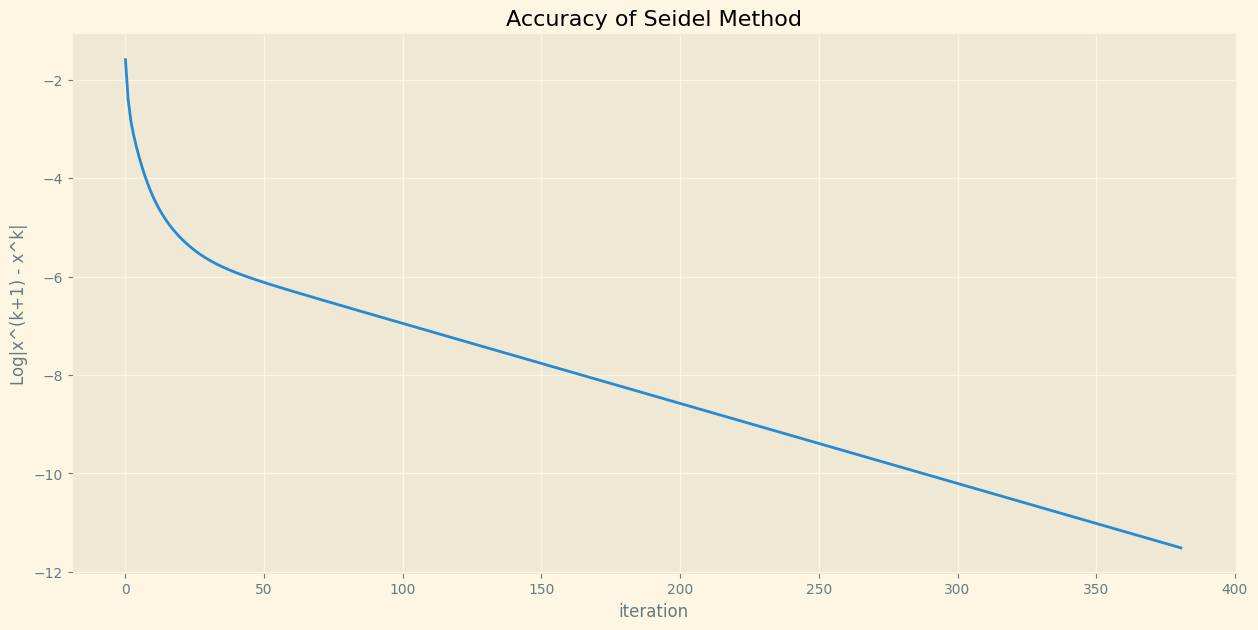

In [6]:
plt.style.use("Solarize_Light2")
plt.figure(figsize=(15,7))
plt.plot(np.arange(len(norm)), np.log(norm))

plt.title("Accuracy of Seidel Method")
plt.ylabel('Log|x^(k+1) - x^k|')
plt.xlabel('iteration')

plt.show()

### References
- Wiki article about Gauss-Seidel method[$^{[0]}$](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method)
- Simple way to generate `SDP`-matrix[$^{[1]}$](https://math.stackexchange.com/questions/357980/how-to-generate-random-symmetric-positive-definite-matrices-using-matlab)